In [ ]:
# ref : https://diane-space.tistory.com/331

In [4]:
import pandas as pd
import numpy as np
import yfinance as yf

There are 1511 observations in the training data
There are 251 observations in the test data


<AxesSubplot:xlabel='Date'>

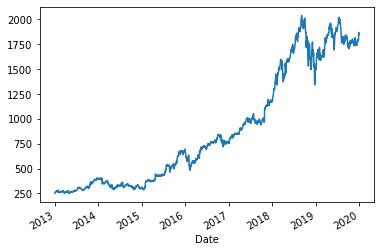

In [2]:
AMZN = yf.download('AMZN', start='2013-01-01', end='2019-12-31', progress=False)
all_data = AMZN[['Adj Close', 'Open', 'High','Low',"Close","Volume"]].round(2)
all_data.head(10)

print("There are "+str(all_data[:'2018'].shape[0])+" observations in the training data")
print("There are "+str(all_data['2019':].shape[0])+" observations in the test data")
all_data['Adj Close'].plot()

In [16]:
all_data

,Adj Close,Open,High,Low,Close,Volume
Date,,,,,,
2012-12-31,250.87,243.75,252.41,242.75,250.87,3419000
2013-01-02,257.31,256.08,258.10,253.26,257.31,3271000
2013-01-03,258.48,257.27,260.88,256.37,258.48,2750900
2013-01-04,259.15,257.58,259.80,256.65,259.15,1874200
2013-01-07,268.46,262.97,269.73,262.67,268.46,4910000
...,...,...,...,...,...,...
2019-12-23,1793.00,1788.26,1793.00,1784.51,1793.00,2136400
2019-12-24,1789.21,1793.81,1795.57,1787.58,1789.21,881300
2019-12-26,1868.77,1801.01,1870.46,1799.50,1868.77,6005400


In [17]:
def ts_train_test(all_data, time_steps, for_periods): 
    """
    input:
     data: dataframe with dates and price data
    output:
     X_train, y_train: data from 2013/1/1-2018-12/31 
     X_test : data from 2019 - 
    time_steps: # of the input time steps 
    for_periods: # of the output time steps 
    """
    # create training and test set 
    ts_train = all_data[:'2018'].iloc[:,0:1].values
    ts_test = all_data['2019':].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)
    
    # create training data of s samples and t time steps 
    X_train = [] 
    y_train = [] 
    y_train_stacked = [] 
    for i in range(time_steps, ts_train_len - 1): 
        X_train.append(ts_train[i-time_steps:i,0])
        y_train.append(ts_train[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    
    # Reshapng X_train for efficient modelling 
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
    
    # Preparing to creat X_test 
    inputs = pd.concat((all_data["Adj Close"][:'2018'], all_data["Adj Close"]['2019':]), axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)
    
    X_test = []
    for i in range(time_steps, ts_test_len+ time_steps- for_periods):
        X_test.append(inputs[i-time_steps:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
    
    return X_train, y_train, X_test 

X_train, y_train, X_test = ts_train_test(all_data,5,2)
X_train.shape[0], X_train.shape[1]

(1505, 5)

In [19]:
X_train.shape, y_train.shape, X_test.shape

((1505, 5, 1), (1505, 2), (249, 5, 1))

In [6]:
# Convert the 3D shape of X_train to a data frame so we can see: 
X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0], X_train.shape[1])))
y_train_see = pd.DataFrame(y_train)
pd.concat([X_train_see, y_train_see], axis = 1)

# Convert the 3D shape of X_test to a data frame so we can see: 
X_test_see = pd.DataFrame(np.reshape(X_test, (X_test.shape[0], X_test.shape[1])))
pd.DataFrame(X_test_see)

print("There are " + str(X_train.shape[0]) + " samples in the training data")
print("There are " + str(X_test.shape[0]) + " samples in the test data")

There are 1505 samples in the training data
There are 249 samples in the test data


In [20]:
def ts_train_test_normalize(all_data, time_steps, for_periods):
    """
    input: 
        data: dataframe with dates and price data
    output: 
        X_train, y_train: data from 2013/1/1-2018/12/31 
        X_test : data from 2019- 
        sc :     insantiated MinMaxScaler object fit to the training data 
    """
    # create training and test set 
    ts_train = all_data[:'2018'].iloc[:,0:1].values
    ts_test = all_data['2019':].iloc[:,0:1].values 
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)
    
    # scale the data 
    from sklearn.preprocessing import MinMaxScaler 
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)
    
    # create training data of s samples and t time steps 
    X_train = [] 
    y_train = [] 
    for i in range(time_steps, ts_train_len-1):
        X_train.append(ts_train_scaled[i-time_steps:i, 0])
        y_train.append(ts_train_scaled[i:i+for_periods, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    
    # Reshaping X_train for efficient modelling 
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1 ))
    
    inputs = pd.concat((all_data["Adj Close"][:'2018'], all_data["Adj Close"]['2019':]), axis=0).values
    inputs = inputs[len(inputs)-len(ts_test)-time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs = sc.transform(inputs)
    
    # Preparing X_test 
    X_test = [] 
    for i in range(time_steps, ts_test_len + time_steps - for_periods):
        X_test.append(inputs[i-time_steps:i,0])
    
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    return X_train, y_train , X_test, sc 

In [21]:
X_train, y_train, X_test, sc = ts_train_test_normalize(all_data, 5,2)

In [24]:
X_train.shape, y_train.shape, X_test.shape

((1505, 5, 1), (1505, 2), (249, 5, 1))

In [27]:
def actual_pred_plot(preds):
    """
    Plot the actual vs predition
    """
    actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
    actual_pred['Adj. Close'] = all_data.loc['2019':,'Adj Close'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]
    
    from keras.metrics import MeanSquaredError 
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Adj. Close']), np.array(actual_pred['prediction']))
    
    return (m.result().numpy(), actual_pred.plot())

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, GRU
from tensorflow.keras.optimizers import SGD

model = Sequential()

model.add(GRU(units=10, ret))

f:\workspace\venv\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


(1239.474, <AxesSubplot:xlabel='Date'>)

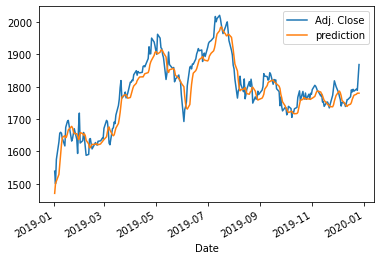

In [15]:
def GRU_model(X_train, y_train, X_test, sc):
    # create a model 
    from keras.models import Sequential 
    from keras.layers import Dense, SimpleRNN, GRU
    # from keras.optimizers import SGD 
    from tensorflow.keras.optimizers import SGD
    
    # The GRU architecture 
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 50, 
                         return_sequences = True, 
                         input_shape = (X_train.shape[1],1), 
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 50, 
                         activation = 'tanh'))
    my_GRU_model.add(Dense(units = 2))
    
    # Compiling the RNN 
    my_GRU_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False), 
                         loss = 'mean_squared_error')
    
    # Fitting to the trainig set 
    my_GRU_model.fit(X_train, y_train, epochs = 50, batch_size = 150, verbose = 0)
    
    GRU_prediction = my_GRU_model.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)
    
    return my_GRU_model, GRU_prediction 

my_GRU_model, GRU_prediction = GRU_model(X_train, y_train, X_test, sc)
GRU_prediction[1:10]
actual_pred_plot(GRU_prediction)